In [ ]:
import os
import numpy as np
from torch import nn
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import (
    EvalCallback,
    CheckpointCallback,
)
from stable_baselines3.common.buffers import *
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import heapq
import random
import torch
from scipy.spatial import KDTree

# IMPLEMENTATION

In [ ]:
# TODO: still need to fix/add "reward" strategy; also check coverage

class SERReplayBuffer(BaseBuffer):
    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        strategy: str,
        priority_queue_size: int,
        priority_queue_percent: float, # 10% use --> 0.1
        device: Union[th.device, str] = "auto",
        n_envs: int = 1,
        optimize_memory_usage: bool = False,
        handle_timeout_termination: bool = True,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs)

        # Adjust buffer size
        self.buffer_size = max(buffer_size // n_envs, 1)

        # Check that the replay buffer can fit into the memory
        if psutil is not None:
            mem_available = psutil.virtual_memory().available

        # there is a bug if both optimize_memory_usage and handle_timeout_termination are true
        # see https://github.com/DLR-RM/stable-baselines3/issues/934
        if optimize_memory_usage and handle_timeout_termination:
            raise ValueError(
                "ReplayBuffer does not support optimize_memory_usage = True "
                "and handle_timeout_termination = True simultaneously."
            )
        self.optimize_memory_usage = optimize_memory_usage

        self.observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=observation_space.dtype)

        if not optimize_memory_usage:
            # When optimizing memory, `observations` contains also the next observation
            self.next_observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=observation_space.dtype)

        self.actions = np.zeros(
            (self.buffer_size, self.n_envs, self.action_dim), dtype=self._maybe_cast_dtype(action_space.dtype)
        )

        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.dones = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        # Handle timeouts termination properly if needed
        # see https://github.com/DLR-RM/stable-baselines3/issues/284
        self.handle_timeout_termination = handle_timeout_termination
        self.timeouts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)

        if psutil is not None:
            total_memory_usage: float = (
                self.observations.nbytes + self.actions.nbytes + self.rewards.nbytes + self.dones.nbytes
            )

            if not optimize_memory_usage:
                total_memory_usage += self.next_observations.nbytes

            if total_memory_usage > mem_available:
                # Convert to GB
                total_memory_usage /= 1e9
                mem_available /= 1e9
                warnings.warn(
                    "This system does not have apparently enough memory to store the complete "
                    f"replay buffer {total_memory_usage:.2f}GB > {mem_available:.2f}GB"
                )
        
        self.strategy = strategy  
        self.gamma = 0.99
        self.dist_threshold = 0.5
        self.priority_queue_size= priority_queue_size
        self.long_term_memory =[]  # (score, (obs, next_obs, action, reward, done))
        self.priority_queue_percent = priority_queue_percent
        self.q_net = None
        self.q_net_target = None

    def add(
        self,
        obs: np.ndarray,
        next_obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        done: np.ndarray,
        infos: list[dict[str, Any]],
    ) -> None:
        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs, *self.obs_shape))
            next_obs = next_obs.reshape((self.n_envs, *self.obs_shape))

        # Reshape to handle multi-dim and discrete action spaces, see GH #970 #1392
        action = action.reshape((self.n_envs, self.action_dim))

        # Copy to avoid modification by reference
        self.observations[self.pos] = np.array(obs)

        if self.optimize_memory_usage:
            self.observations[(self.pos + 1) % self.buffer_size] = np.array(next_obs)
        else:
            self.next_observations[self.pos] = np.array(next_obs)

        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.dones[self.pos] = np.array(done)

        if self.handle_timeout_termination:
            self.timeouts[self.pos] = np.array([info.get("TimeLimit.truncated", False) for info in infos])

        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True
            self.pos = 0

        # compute score using given strategy and push to priority queue
        # will get rid of the lowest score among the ones stored in long term mem if we exceed memory limit
        
        idx = (self.pos - 1) % self.buffer_size
        for env_idx in range(self.n_envs):
            score = self.compute_score(obs[env_idx], next_obs[env_idx], action[env_idx], reward[env_idx], done[env_idx])
            heapq.heappush(self.long_term_memory, (score, idx, env_idx))

        if len(self.long_term_memory) > self.priority_queue_size:
            heapq.heappop(self.long_term_memory)

    def sample(self, batch_size: int, env: Optional[VecNormalize] = None):
        #print("sampling")
        long_size=int(batch_size*self.priority_queue_percent)
        fifo_size=batch_size-long_size
        
        # sample from FIFO
        if not self.optimize_memory_usage:
            return super().sample(batch_size=batch_size, env=env)
        # Do not sample the element with index `self.pos` as the transitions is invalid
        # (we use only one array to store `obs` and `next_obs`)
        if self.full:
            fifo_inds = (np.random.randint(1, self.buffer_size, size=fifo_size) + self.pos) % self.buffer_size
        else:
            fifo_inds = np.random.randint(0, self.pos, size=fifo_size)

        fifo_samples = self._get_samples(fifo_inds, env=env)

        # sample from long term memoru
        if len(self.long_term_memory) >= long_size:
            sampled_long_mem = random.sample(self.long_term_memory, long_size)
        else:
            sampled_long_mem = self.long_term_memory

        buffer_idxs = [idx for _, idx, env in sampled_long_mem]
        env_idxs = [env for _, idx, env in sampled_long_mem]

        long_obs = self.observations[buffer_idxs, env_idxs]
        if self.optimize_memory_usage:
            long_next_obs = self.observations[(np.array(buffer_idxs) + 1) % self.buffer_size, env_idxs]
        else:
            long_next_obs = self.next_observations[buffer_idxs, env_idxs]

        long_actions = self.actions[buffer_idxs, env_idxs]
        long_rewards = self.rewards[buffer_idxs, env_idxs].reshape(-1, 1)
        long_dones = (self.dones[buffer_idxs, env_idxs] * (1 - self.timeouts[buffer_idxs, env_idxs])).reshape(-1, 1)

        long_obs = self.to_torch(self._normalize_obs(long_obs, env))
        long_next_obs = self.to_torch(self._normalize_obs(long_next_obs, env))
        long_actions = self.to_torch(long_actions)
        long_rewards = self.to_torch(self._normalize_reward(long_rewards, env))
        long_dones = self.to_torch(long_dones)

        # combine FIFO + long-term mem
        obs = torch.cat([fifo_samples.observations, long_obs], dim=0)
        next_obs = torch.cat([fifo_samples.next_observations, long_next_obs], dim=0)
        actions = torch.cat([fifo_samples.actions, long_actions], dim=0)
        rewards = torch.cat([fifo_samples.rewards, long_rewards], dim=0)
        dones = torch.cat([fifo_samples.dones, long_dones], dim=0)

        return ReplayBufferSamples(obs, actions, next_obs, dones, rewards)

    def _get_samples(self, batch_inds: np.ndarray, env: Optional[VecNormalize] = None) -> ReplayBufferSamples:
        # Sample randomly the env idx
        env_indices = np.random.randint(0, high=self.n_envs, size=(len(batch_inds),))

        if self.optimize_memory_usage:
            next_obs = self._normalize_obs(self.observations[(batch_inds + 1) % self.buffer_size, env_indices, :], env)
        else:
            next_obs = self._normalize_obs(self.next_observations[batch_inds, env_indices, :], env)

        data = (
            self._normalize_obs(self.observations[batch_inds, env_indices, :], env),
            self.actions[batch_inds, env_indices, :],
            next_obs,
            # Only use dones that are not due to timeouts
            # deactivated by default (timeouts is initialized as an array of False)
            (self.dones[batch_inds, env_indices] * (1 - self.timeouts[batch_inds, env_indices])).reshape(-1, 1),
            self._normalize_reward(self.rewards[batch_inds, env_indices].reshape(-1, 1), env),
        )
        #print("sampling done")
        return ReplayBufferSamples(*tuple(map(self.to_torch, data)))

    def compute_score(self, obs, next_obs, action, reward, done):
        if self.strategy == "reward":
            return float(abs(reward)) # TODO: need to implement this one
        elif self.strategy == "distribution":
            return float(np.random.normal()) 
        
        elif self.strategy== "surprise":
            with torch.no_grad():
                obs_tensor = self.to_torch(obs).unsqueeze(0)
                next_obs_tensor = self.to_torch(next_obs).unsqueeze(0)  
                action_tensor = self.to_torch(action).long().unsqueeze(0)  
                reward_tensor = self.to_torch(reward).unsqueeze(0)
                done_tensor = self.to_torch(done).unsqueeze(0).float()

                q_values = self.q_net(obs_tensor)
                q_sa = q_values.gather(1, action_tensor)

                next_q_values = self.q_net_target(next_obs_tensor)
                max_q_next = next_q_values.max(1, keepdim=True).values

                td_target = reward_tensor + self.gamma * (1.0 - done_tensor) * max_q_next
                td_error = torch.abs(td_target - q_sa)
                return float(td_error.item())
            
        elif self.strategy == "coverage": 
           norm_obs = self._normalize_obs(obs, env=None).flatten()
           # build KD tree
           all = []
           for _, idx, env in self.long_term_memory:
               exist_obs = self._normalize_obs(self.observations[idx, env], env=None).flatten()
               all.append(exist_obs)

           if len(all) == 0:
               return 0
           tree= KDTree(np.stack(all))
           neighbors = tree.query_ball_point(norm_obs, r=self.dist_threshold)
           count= len(neighbors)
           return -count
        return 0
    
    def set_q_nets(self, q_net, q_net_target):
        self.q_net = q_net
        self.q_net_target = q_net_target
    
    @staticmethod
    def _maybe_cast_dtype(dtype: np.typing.DTypeLike) -> np.typing.DTypeLike:
        """
        Cast `np.float64` action datatype to `np.float32`,
        keep the others dtype unchanged.
        See GH#1572 for more information.

        :param dtype: The original action space dtype
        :return: ``np.float32`` if the dtype was float64,
            the original dtype otherwise.
        """
        if dtype == np.float64:
            return np.float32
        return dtype

In [3]:
def train(env_spawner, eval_env_spawner, config):
    print("Initializing...")

    # Unpack config
    log_dir = config["log_dir"]
    n_envs = config["n_envs"]
    ckpt = config.get("checkpoint", None)
    policy_args = config["policy_args"]
    algo_kwargs = config["algo_kwargs"]
    checkpoint_freq = config["checkpoint_freq"]
    eval_freq = config["eval_freq"]
    n_eval_episodes = config["n_eval_episodes"]
    n_train_timesteps = config["n_train_timesteps"]
    verbose_training = config["verbose_training"]

    # Setup
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    env = VecMonitor(DummyVecEnv(
        [env_spawner] * n_envs,
    ))
    eval_env = VecMonitor(DummyVecEnv([eval_env_spawner]))

    if ckpt is None:
        model = DQN(
            policy="MlpPolicy",
            env=env,
            policy_kwargs=policy_args,
            **algo_kwargs,
        )
    else:
        model = DQN.load(
            path=ckpt,
            env=env,
        )

    if isinstance(model.replay_buffer, SERReplayBuffer):    
        model.replay_buffer.set_q_nets(model.q_net, model.q_net_target)

    checkpoint_callback = CheckpointCallback(
        save_freq=checkpoint_freq,
        save_path=log_dir,
        name_prefix=os.path.basename(log_dir),
        verbose=0,
    )

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=log_dir,
        log_path=log_dir,
        eval_freq=eval_freq,
        n_eval_episodes=n_eval_episodes,
        deterministic=True,
        render=False,
        verbose=0,
    )

    # Train
    print("Training...")
    model.learn(
        total_timesteps=n_train_timesteps,
        callback=[
            eval_callback,
            checkpoint_callback,
        ],
        log_interval=1 if verbose_training else None,
        reset_num_timesteps=False,
        progress_bar=True if verbose_training else False,
    )

In [4]:
def plot_evaluations(log_dir):
    evaluations = np.load(os.path.join(log_dir, "evaluations.npz"))
    timesteps = evaluations["timesteps"]
    results_all = evaluations["results"]  # shape: (eval_rounds, episodes_per_eval)
    
    mean_returns = np.mean(results_all, axis=1)
    std_returns = np.std(results_all, axis=1)
    num_episodes_averaged = results_all.shape[1]
    print("Evaluations: min: {}, max: {}, std: {}".format(
        np.min(results_all), np.max(results_all), np.std(results_all)))
        
    plt.figure(figsize=(5, 5))
    plt.plot(timesteps, mean_returns, label='Mean Return')
    plt.fill_between(timesteps, mean_returns - std_returns, mean_returns + std_returns,
                     alpha=0.3, label='Std Dev')
    plt.xlabel('Timesteps')
    plt.ylabel('Returns (averaged over {} episodes)'.format(num_episodes_averaged))
    plt.title('Evaluation Returns')
    plt.legend()
    plt.grid()

    plt.savefig(os.path.join(log_dir, "evaluations.png"))
    plt.show()

# EXPERIMENTATION

In [5]:
def make_env():
    env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
    # env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)
    return env

def make_eval_env():
    # modify if you want the evaluation environment to be different
    env = gym.make('forex-v0', frame_bound=(101, 1001), window_size=10)
    # env = gym.make('stocks-v0', window_size=10)
    return env

In [6]:
base_config = {
    # TRAINING PARAMETERS
    "log_dir": "./train_logs/base",
    "n_envs": 32, # number of parallel environments to use for training
    "checkpoint": None, # path to a checkpoint to load from
    "checkpoint_freq": 10000, # save a model checkpoint every _ steps
    "eval_freq": 5000, # evaluate the model every _ steps
    "n_eval_episodes": 10, # number of episodes to evaluate the model on
    "n_train_timesteps": int(1e6), # total number of training steps
    "verbose_training": True,
    # RL PARAMETERS (all set to defaults right now, except for seed)
    "policy_args": {
        "net_arch": [64, 64],
        "activation_fn": nn.ReLU,
    },
    "algo_kwargs": {
        "learning_rate": 1e-4,
        "buffer_size": int(1e6),
        "learning_starts": 100, # how many steps of the model to collect transitions for before learning starts
        "batch_size": 32,
        "tau": 1.0, # the soft update coefficient ("Polyak update", between 0 and 1) default 1 for hard update
        "gamma": 0.99,
        "train_freq": (4, 'step'), # Update the model every ``train_freq`` steps.
        "gradient_steps": 1, # How many gradient steps to do after each rollout
        "target_update_interval": int(1e4), # update the target network every ``target_update_interval`` environment steps.
        "exploration_fraction": 0.1, # fraction of entire training period over which the exploration rate is reduced
        "exploration_initial_eps": 1.0, # initial value of random action probability
        "exploration_final_eps": 0.05, # final value of random action probability
        "seed": 42,
    }
}

In [7]:
fifo_config = base_config.copy()
fifo_config["log_dir"] = "./train_logs/fifo"
fifo_config["algo_kwargs"]["replay_buffer_class"] = ReplayBuffer


In [ ]:
train(make_env, make_eval_env, fifo_config)

Initializing...


Output()

Training...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


KeyboardInterrupt: 

Evaluations: min: 0.0, max: 0.0, std: 0.0


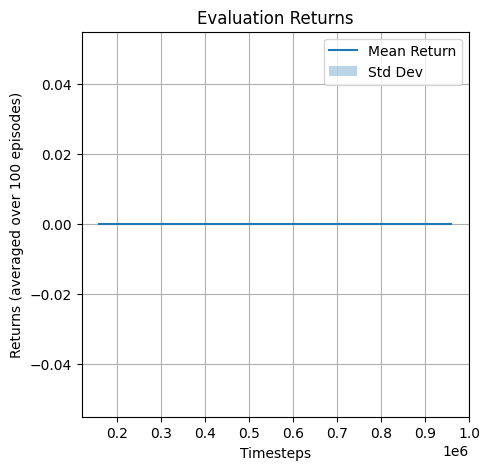

In [ ]:
plot_evaluations(fifo_config["log_dir"])

In [ ]:
ser_config = base_config.copy()
ser_config["log_dir"] = "./train_logs/ser"
ser_config["algo_kwargs"]["replay_buffer_class"] = SERReplayBuffer

ser_config["strategy"] = "surprise"
ser_config["priority_queue_size"] = 5000
ser_config["priority_queue_percent"] = 0.5


ser_config["algo_kwargs"]["replay_buffer_kwargs"] = {
    "strategy": ser_config["strategy"],
    "priority_queue_size": ser_config["priority_queue_size"],
    "priority_queue_percent" : ser_config["priority_queue_percent"]
}

train(make_env, make_eval_env, ser_config) 

Initializing...


Output()

Training...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

sampling done

KeyboardInterrupt: 

Evaluations: min: 0.0, max: 0.0, std: 0.0


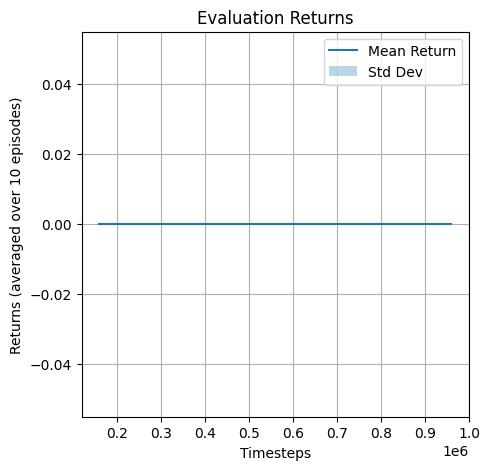

In [ ]:
plot_evaluations(ser_config["log_dir"])